<a href="https://colab.research.google.com/github/aquapathos/MLLesson/blob/master/VizDoomGym%E3%83%86%E3%82%B9%E3%83%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%time
!apt-get install libgtk2.0-dev libsdl2-dev -qq -y >/dev/null || exit 2
!git clone https://github.com/shakenes/vizdoomgym.git
%cd /content/vizdoomgym
!pip install -e . >/dev/null || exit 2
!pip install keras-rl2 >/dev/null || exit 2

Extracting templates from packages: 100%
Cloning into 'vizdoomgym'...
remote: Enumerating objects: 272, done.
remote: Counting objects: 100% (272/272), done.
remote: Compressing objects: 100% (172/172), done.
remote: Total 579 (delta 139), reused 150 (delta 72), pack-reused 307
Receiving objects: 100% (579/579), 186.79 KiB | 5.84 MiB/s, done.
Resolving deltas: 100% (305/305), done.
/content/vizdoomgym
CPU times: user 596 ms, sys: 96.2 ms, total: 693 ms
Wall time: 4min 50s


Cannot connect to "None"


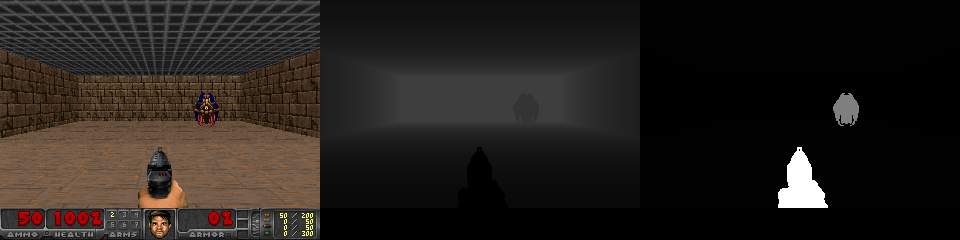

In [2]:
import gym
import vizdoomgym
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

env = gym.make('VizdoomBasic-v0', depth=True, labels=True, position=True, health=True)
width = 320
hight = 240
observation = np.zeros((hight,width*3,3),dtype=np.uint8)
state = env.reset()
env.render()
action = env.action_space.sample()
state, reward, done, info = env.step(action)
img = cv2.cvtColor(state[0],cv2.COLOR_RGB2BGR)
depth = cv2.cvtColor(state[1],cv2.COLOR_GRAY2BGR)
label = cv2.cvtColor(state[2],cv2.COLOR_GRAY2BGR)
observation[:,:width,:]=img
observation[:,width:width*2,:]=depth
observation[:,width*2:width*3,:]=label
cv2_imshow(observation)
env.close()

- Keras 2.4.3
- keras-rl2 1.0.4
- tensorflow 2.3.0

# GRAY
- フレームバッファをグレイ変換し、中央の1/3だけを使用する。  
- action_repetition=10
- target_model_update=0.0025
- eps=0.3  
この周辺で最適化をこころみる


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 18, 64, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 5, 16, 32)         832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 2, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                16416     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 17,347
Trainable params: 17,347
Non-trainable params: 0
____________________________________________________

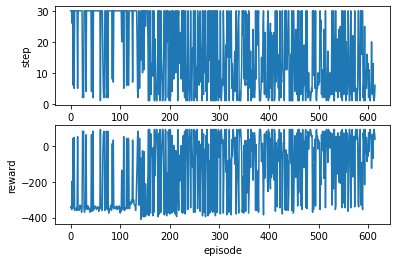

CPU times: user 2min 32s, sys: 10.5 s, total: 2min 43s
Wall time: 3min 51s


In [3]:
%%time
import gym
import vizdoomgym
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense, Activation, Flatten, Conv2D,Reshape,MaxPooling2D
from tensorflow.keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory
import cv2
import matplotlib.pyplot as plt
width = 64
height = 48
GL = 18
GH = 36
middle=GH-GL
ENV_NAME = 'VizdoomBasic-v0'

from vizdoomgym.envs.vizdoom_env_definitions import VizdoomBasic
class MyBasic(VizdoomBasic):
    def step(self, action):
        act = np.zeros(self.action_space.n)
        act[action] = 1
        act = np.uint8(act)
        act = act.tolist()
        reward = self.game.make_action(act)
        self.state = self.game.get_state()
        done = self.game.is_episode_finished()
        info = {"dummy": 0.0}
        return self.collect_observations(), reward, done, info
    def reset(self):
        self.game.new_episode()
        self.state = self.game.get_state()
        return self.collect_observations()
    def collect_observations(self):
        if self.state is not None:
            obs = np.transpose(self.state.screen_buffer, (1, 2, 0))
        else:
            obs = np.zeros(self.observation_space.shape, dtype=np.uint8)
        obs = cv2.resize(obs,(width,height))[GL:GH,:]
        obs = cv2.cvtColor(obs,cv2.COLOR_RGB2GRAY)
        observation = np.reshape(obs,(middle,width,1))/255
        return observation

# env = gym.make(ENV_NAME, depth=False,bels=False, position=False, health=False)
env = MyBasic(depth=False,bels=False, position=False, health=False)
input_shape = env.observation_space.shape
nb_actions = env.action_space.n
# DQN
model = Sequential()
model.add(Reshape((middle,width,1),input_shape=(1,middle,width,1)))
model.add(Conv2D(32, (5, 5), activation='relu',strides=(4,4),padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Conv2D(32, (5, 5), activation='relu',padding="same"))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(nb_actions, activation='linear'))
#model.add(Dense(nb_actions, activation='softmax'))
print(model.summary())

memory = SequentialMemory(limit=10000, window_length=1)
policy = EpsGreedyQPolicy(eps=0.3)
#env = gym.make('VizdoomBasic-v0', depth=False, labels=False, position=False, health=False)
dqn = DQNAgent(model=model, nb_actions=nb_actions,policy=policy,gamma=0.99, memory=memory, enable_double_dqn=True,
                target_model_update=0.0025,dueling_type='avg',nb_steps_warmup=3000)
dqn.compile(Adam(lr=0.001), metrics=['mae'])
history = dqn.fit(env, nb_steps=10000, action_repetition=10,visualize=False, verbose=1)
dqn.save_weights('/content/drive/My Drive/tmp/vizdoomgym/dqn1_{}_params.h5f'.format(ENV_NAME), overwrite=True)
# 結果を表示

plt.subplot(2,1,1)
plt.plot(history.history["nb_episode_steps"])
plt.ylabel("step")
plt.subplot(2,1,2)
plt.plot(history.history["episode_reward"])
plt.xlabel("episode")
plt.ylabel("reward")
plt.show() 

# dqn.test(env, nb_episodes=5, visualize=True)

# COLOR

中間層のシナプス数が支配的なので、入力を白黒にするかカラーにするかで、変数の数はあまり変わらない。

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 18, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 16, 32)         2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 8, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                16416     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 18,947
Trainable params: 18,947
Non-trainable params: 0
__________________________________________________

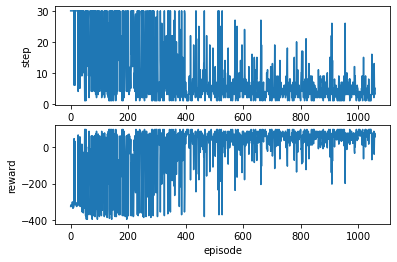

CPU times: user 3min 5s, sys: 12.7 s, total: 3min 17s
Wall time: 4min 12s


In [4]:
%%time
width = 64
height = 48
GL = 18
GH = 36
middle=GH-GL
ENV_NAME = 'VizdoomBasic-v0'

from vizdoomgym.envs.vizdoom_env_definitions import VizdoomBasic
class MyBasic(VizdoomBasic):
    def step(self, action):
        act = np.zeros(self.action_space.n)
        act[action] = 1
        act = np.uint8(act)
        act = act.tolist()
        reward = self.game.make_action(act)
        self.state = self.game.get_state()
        done = self.game.is_episode_finished()
        info = {"dummy": 0.0}
        return self.collect_observations(), reward, done, info
    def reset(self):
        self.game.new_episode()
        self.state = self.game.get_state()
        return self.collect_observations()
    def collect_observations(self):
        if self.state is not None:
            obs = np.transpose(self.state.screen_buffer, (1, 2, 0))
        else:
            obs = np.zeros(self.observation_space.shape, dtype=np.uint8)
        obs = cv2.resize(obs,(width,height))[GL:GH,:]
        # obs = cv2.cvtColor(obs,cv2.COLOR_RGB2GRAY)
        observation = np.reshape(obs,(middle,width,3))/255
        return observation

# env = gym.make(ENV_NAME, depth=False,bels=False, position=False, health=False)
env = MyBasic(depth=False,bels=False, position=False, health=False)
input_shape = env.observation_space.shape
nb_actions = env.action_space.n
# DQN
model = Sequential()
model.add(Reshape((middle,width,3),input_shape=(1,middle,width,3)))
model.add(Conv2D(32, (5, 5), activation='relu',strides=(4,4),padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Conv2D(32, (5, 5), activation='relu',padding="same"))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(nb_actions, activation='linear'))
#model.add(Dense(nb_actions, activation='softmax'))
print(model.summary())

memory = SequentialMemory(limit=10000, window_length=1)
policy = EpsGreedyQPolicy(eps=0.3)
#env = gym.make('VizdoomBasic-v0', depth=False, labels=False, position=False, health=False)
dqn = DQNAgent(model=model, nb_actions=nb_actions,policy=policy,gamma=0.99, memory=memory, enable_double_dqn=True,
                target_model_update=0.01,dueling_type='avg',nb_steps_warmup=1000)
dqn.compile(Adam(lr=0.0025), metrics=['mae'])
history = dqn.fit(env, nb_steps=10000, action_repetition=10,visualize=False, verbose=1)
dqn.save_weights('/content/drive/My Drive/tmp/vizdoomgym/dqn1_{}_params.h5f'.format(ENV_NAME), overwrite=True)
# 結果を表示

plt.subplot(2,1,1)
plt.plot(history.history["nb_episode_steps"])
plt.ylabel("step")
plt.subplot(2,1,2)
plt.plot(history.history["episode_reward"])
plt.xlabel("episode")
plt.ylabel("reward")
plt.show() 

# dqn.test(env, nb_episodes=5, visualize=True)

カラーの方があきらかに有利である。　パラメータ数は中間層が支配的なので、カラーだからといって3倍になるわけではない。ではないどころか、グレイの 17,347 に対し、カラーは　18,947　。あまり差はない。

ということで、以下ではカラーを利用。

# action_repetition = 7

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 18, 64, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 16, 32)         2432      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 8, 32)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                16416     
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 18,947
Trainable params: 18,947
Non-trainable params: 0
__________________________________________________

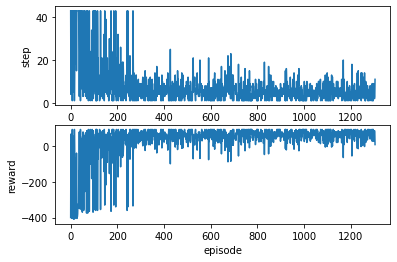

CPU times: user 2min 51s, sys: 12.5 s, total: 3min 4s
Wall time: 3min 38s


In [5]:
%%time
width = 64
height = 48
GL = 18
GH = 36
middle=GH-GL
ENV_NAME = 'VizdoomBasic-v0'

from vizdoomgym.envs.vizdoom_env_definitions import VizdoomBasic
class MyBasic(VizdoomBasic):
    def step(self, action):
        act = np.zeros(self.action_space.n)
        act[action] = 1
        act = np.uint8(act)
        act = act.tolist()
        reward = self.game.make_action(act)
        self.state = self.game.get_state()
        done = self.game.is_episode_finished()
        info = {"dummy": 0.0}
        return self.collect_observations(), reward, done, info
    def reset(self):
        self.game.new_episode()
        self.state = self.game.get_state()
        return self.collect_observations()
    def collect_observations(self):
        if self.state is not None:
            obs = np.transpose(self.state.screen_buffer, (1, 2, 0))
        else:
            obs = np.zeros(self.observation_space.shape, dtype=np.uint8)
        obs = cv2.resize(obs,(width,height))[GL:GH,:]
        # obs = cv2.cvtColor(obs,cv2.COLOR_RGB2GRAY)
        observation = np.reshape(obs,(middle,width,3))/255
        return observation

# env = gym.make(ENV_NAME, depth=False,bels=False, position=False, health=False)
env = MyBasic(depth=False,bels=False, position=False, health=False)
input_shape = env.observation_space.shape
nb_actions = env.action_space.n
# DQN
model = Sequential()
model.add(Reshape((middle,width,3),input_shape=(1,middle,width,3)))
model.add(Conv2D(32, (5, 5), activation='relu',strides=(4,4),padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Conv2D(32, (5, 5), activation='relu',padding="same"))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(nb_actions, activation='linear'))
#model.add(Dense(nb_actions, activation='softmax'))
print(model.summary())

memory = SequentialMemory(limit=10000, window_length=1)
policy = EpsGreedyQPolicy(eps=0.3)
#env = gym.make('VizdoomBasic-v0', depth=False, labels=False, position=False, health=False)
dqn = DQNAgent(model=model, nb_actions=nb_actions,policy=policy,gamma=0.99, memory=memory, enable_double_dqn=True,
                target_model_update=0.01,dueling_type='avg',nb_steps_warmup=1000)
dqn.compile(Adam(lr=0.0025), metrics=['mae'])
history = dqn.fit(env, nb_steps=10000, action_repetition=7,visualize=False, verbose=1)
dqn.save_weights('/content/drive/My Drive/tmp/vizdoomgym/dqn1_{}_params.h5f'.format(ENV_NAME), overwrite=True)
# 結果を表示

plt.subplot(2,1,1)
plt.plot(history.history["nb_episode_steps"])
plt.ylabel("step")
plt.subplot(2,1,2)
plt.plot(history.history["episode_reward"])
plt.xlabel("episode")
plt.ylabel("reward")
plt.show() 

# dqn.test(env, nb_episodes=5, visualize=True)

# action_repetition の最適化

| action_repetition | reward  | 
| ----------------- | ------- | 
| 3                 | -1.6244 | 
| 5                 | -4.5028 | 
| 6                 | -2.6943 | 
| 7                 | 5.0217  | 
| 8                 |  1.1227 | 
 | 10                | 1.5733  | 

 ７がベスト

# epsiron = 0.3

ここまでのハイパーパラメータ設定では、action_repetition=７がベストなので、７に固定して他を変えてみる

epsiron を変えてみた結果は次の通り。

| epsiron | reward | 
| ------- | ------ | 
| 0.1     | 2.0150 | 
| 0.2     | 2.8072 | 
| 0.25    | 4.3137 | 
| 0.3     | 5.0217 | 
| 0.4     | 5.0021 | 

action_repetition=7 では epsiron=0.3 がベストっぽい

# Adam(lr=０．００６)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 18, 64, 3)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 16, 32)         2432      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 8, 32)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                16416     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 99        
Total params: 18,947
Trainable params: 18,947
Non-trainable params: 0
__________________________________________________

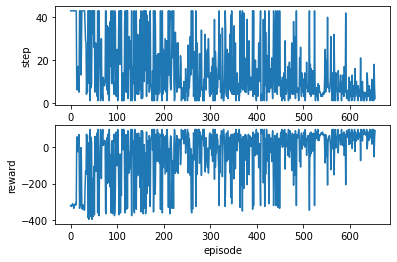

CPU times: user 2min 46s, sys: 11.4 s, total: 2min 57s
Wall time: 3min 32s


In [6]:
%%time
width = 64
height = 48
GL = 18
GH = 36
middle=GH-GL
ENV_NAME = 'VizdoomBasic-v0'

from vizdoomgym.envs.vizdoom_env_definitions import VizdoomBasic
class MyBasic(VizdoomBasic):
    def step(self, action):
        act = np.zeros(self.action_space.n)
        act[action] = 1
        act = np.uint8(act)
        act = act.tolist()
        reward = self.game.make_action(act)
        self.state = self.game.get_state()
        done = self.game.is_episode_finished()
        info = {"dummy": 0.0}
        return self.collect_observations(), reward, done, info
    def reset(self):
        self.game.new_episode()
        self.state = self.game.get_state()
        return self.collect_observations()
    def collect_observations(self):
        if self.state is not None:
            obs = np.transpose(self.state.screen_buffer, (1, 2, 0))
        else:
            obs = np.zeros(self.observation_space.shape, dtype=np.uint8)
        obs = cv2.resize(obs,(width,height))[GL:GH,:]
        # obs = cv2.cvtColor(obs,cv2.COLOR_RGB2GRAY)
        observation = np.reshape(obs,(middle,width,3))/255
        return observation

# env = gym.make(ENV_NAME, depth=False,bels=False, position=False, health=False)
env = MyBasic(depth=False,bels=False, position=False, health=False)
input_shape = env.observation_space.shape
nb_actions = env.action_space.n
# DQN
model = Sequential()
model.add(Reshape((middle,width,3),input_shape=(1,middle,width,3)))
model.add(Conv2D(32, (5, 5), activation='relu',strides=(4,4),padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Conv2D(32, (5, 5), activation='relu',padding="same"))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(nb_actions, activation='linear'))
#model.add(Dense(nb_actions, activation='softmax'))
print(model.summary())

memory = SequentialMemory(limit=10000, window_length=1)
policy = EpsGreedyQPolicy(eps=0.3)
#env = gym.make('VizdoomBasic-v0', depth=False, labels=False, position=False, health=False)
dqn = DQNAgent(model=model, nb_actions=nb_actions,policy=policy,gamma=0.99, memory=memory, enable_double_dqn=True,
                target_model_update=0.01,dueling_type='avg',nb_steps_warmup=1000)
dqn.compile(Adam(lr=0.006), metrics=['mae'])
history = dqn.fit(env, nb_steps=10000, action_repetition=7,visualize=False, verbose=1)
dqn.save_weights('/content/drive/My Drive/tmp/vizdoomgym/dqn1_{}_params.h5f'.format(ENV_NAME), overwrite=True)
# 結果を表示

plt.subplot(2,1,1)
plt.plot(history.history["nb_episode_steps"])
plt.ylabel("step")
plt.subplot(2,1,2)
plt.plot(history.history["episode_reward"])
plt.xlabel("episode")
plt.ylabel("reward")
plt.show() 

# dqn.test(env, nb_episodes=5, visualize=True)

| lr     | reward  | 
| ------ | ------- | 
| 0.001  | -2.7264 | 
| 0.0025 | 5.0217  | 
| 0.005  | 6.4767  | 
| 0.006  | 7.0099  | 
| 0.007  |  6.5710 | 

lr = 0.006 あたりが最適

# target_model_update　 =　0.01

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 18, 64, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 5, 16, 32)         2432      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 2, 8, 32)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                16416     
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 99        
Total params: 18,947
Trainable params: 18,947
Non-trainable params: 0
__________________________________________________

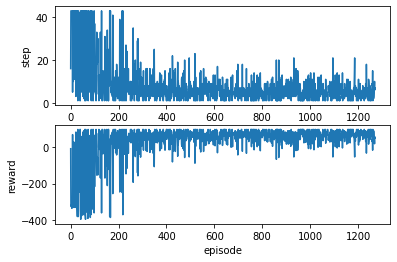

CPU times: user 2min 56s, sys: 12.1 s, total: 3min 8s
Wall time: 3min 42s


In [7]:
%%time
width = 64
height = 48
GL = 18
GH = 36
middle=GH-GL
ENV_NAME = 'VizdoomBasic-v0'

from vizdoomgym.envs.vizdoom_env_definitions import VizdoomBasic
class MyBasic(VizdoomBasic):
    def step(self, action):
        act = np.zeros(self.action_space.n)
        act[action] = 1
        act = np.uint8(act)
        act = act.tolist()
        reward = self.game.make_action(act)
        self.state = self.game.get_state()
        done = self.game.is_episode_finished()
        info = {"dummy": 0.0}
        return self.collect_observations(), reward, done, info
    def reset(self):
        self.game.new_episode()
        self.state = self.game.get_state()
        return self.collect_observations()
    def collect_observations(self):
        if self.state is not None:
            obs = np.transpose(self.state.screen_buffer, (1, 2, 0))
        else:
            obs = np.zeros(self.observation_space.shape, dtype=np.uint8)
        obs = cv2.resize(obs,(width,height))[GL:GH,:]
        # obs = cv2.cvtColor(obs,cv2.COLOR_RGB2GRAY)
        observation = np.reshape(obs,(middle,width,3))/255
        return observation

# env = gym.make(ENV_NAME, depth=False,bels=False, position=False, health=False)
env = MyBasic(depth=False,bels=False, position=False, health=False)
input_shape = env.observation_space.shape
nb_actions = env.action_space.n
# DQN
model = Sequential()
model.add(Reshape((middle,width,3),input_shape=(1,middle,width,3)))
model.add(Conv2D(32, (5, 5), activation='relu',strides=(4,4),padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Conv2D(32, (5, 5), activation='relu',padding="same"))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(nb_actions, activation='linear'))
#model.add(Dense(nb_actions, activation='softmax'))
print(model.summary())

memory = SequentialMemory(limit=10000, window_length=1)
policy = EpsGreedyQPolicy(eps=0.3)
#env = gym.make('VizdoomBasic-v0', depth=False, labels=False, position=False, health=False)
dqn = DQNAgent(model=model, nb_actions=nb_actions,policy=policy,gamma=0.99, memory=memory, enable_double_dqn=True,
                target_model_update=0.05,dueling_type='avg',nb_steps_warmup=1000)
dqn.compile(Adam(lr=0.006), metrics=['mae'])
history = dqn.fit(env, nb_steps=10000, action_repetition=7,visualize=False, verbose=1)
dqn.save_weights('/content/drive/My Drive/tmp/vizdoomgym/dqn1_{}_params.h5f'.format(ENV_NAME), overwrite=True)
# 結果を表示

plt.subplot(2,1,1)
plt.plot(history.history["nb_episode_steps"])
plt.ylabel("step")
plt.subplot(2,1,2)
plt.plot(history.history["episode_reward"])
plt.xlabel("episode")
plt.ylabel("reward")
plt.show() 

# dqn.test(env, nb_episodes=5, visualize=True)

# 複雑なネットワーク

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 18, 64, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 16, 32)         2432      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 8, 32)          25632     
_________________________________________________________________
flatten_5 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                24608     
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 99        
Total params: 52,771
Trainable params: 52,771
Non-trainable params: 0
__________________________________________________

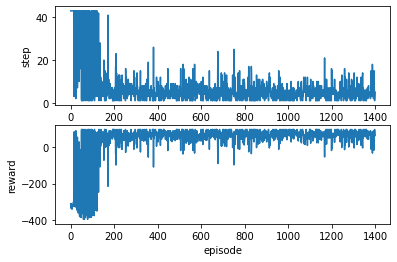

CPU times: user 3min 5s, sys: 13.6 s, total: 3min 19s
Wall time: 3min 52s


In [8]:
%%time
width = 64
height = 48
GL = 18
GH = 36
middle=GH-GL
ENV_NAME = 'VizdoomBasic-v0'

from vizdoomgym.envs.vizdoom_env_definitions import VizdoomBasic
class MyBasic(VizdoomBasic):
    def step(self, action):
        act = np.zeros(self.action_space.n)
        act[action] = 1
        act = np.uint8(act)
        act = act.tolist()
        reward = self.game.make_action(act)
        self.state = self.game.get_state()
        done = self.game.is_episode_finished()
        info = {"dummy": 0.0}
        return self.collect_observations(), reward, done, info
    def reset(self):
        self.game.new_episode()
        self.state = self.game.get_state()
        return self.collect_observations()
    def collect_observations(self):
        if self.state is not None:
            obs = np.transpose(self.state.screen_buffer, (1, 2, 0))
        else:
            obs = np.zeros(self.observation_space.shape, dtype=np.uint8)
        obs = cv2.resize(obs,(width,height))[GL:GH,:]
        # obs = cv2.cvtColor(obs,cv2.COLOR_RGB2GRAY)
        observation = np.reshape(obs,(middle,width,3))/255
        return observation

# env = gym.make(ENV_NAME, depth=False,bels=False, position=False, health=False)
env = MyBasic(depth=False,bels=False, position=False, health=False)
input_shape = env.observation_space.shape
nb_actions = env.action_space.n
# DQN
model = Sequential()
model.add(Reshape((middle,width,3),input_shape=(1,middle,width,3)))
model.add(Conv2D(32, (5, 5), activation='relu',strides=(4,4),padding="same"))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (5, 5), activation='relu',strides=(2,2),padding="same"))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(nb_actions, activation='linear'))
#model.add(Dense(nb_actions, activation='softmax'))
print(model.summary())

memory = SequentialMemory(limit=10000, window_length=1)
policy = EpsGreedyQPolicy(eps=0.3)
#env = gym.make('VizdoomBasic-v0', depth=False, labels=False, position=False, health=False)
dqn = DQNAgent(model=model, nb_actions=nb_actions,policy=policy,gamma=0.99, memory=memory, enable_double_dqn=True,
                target_model_update=0.05,dueling_type='avg',nb_steps_warmup=1000)
dqn.compile(Adam(lr=0.006), metrics=['mae'])
history = dqn.fit(env, nb_steps=10000, action_repetition=7,visualize=False, verbose=1)
dqn.save_weights('/content/drive/My Drive/tmp/vizdoomgym/dqn1_{}_params.h5f'.format(ENV_NAME), overwrite=True)
# 結果を表示

plt.subplot(2,1,1)
plt.plot(history.history["nb_episode_steps"])
plt.ylabel("step")
plt.subplot(2,1,2)
plt.plot(history.history["episode_reward"])
plt.xlabel("episode")
plt.ylabel("reward")
plt.show() 

# dqn.test(env, nb_episodes=5, visualize=True)

畳み込みを2段にしてみたら、少しよくなった。　パラメータ数が3倍近いが、GPUの効果か、時間は2倍未満で済んでいる。

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_6 (Reshape)          (None, 18, 64, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 16, 24)         1824      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 5, 16, 24)         14424     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 8, 24)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 24)                9240      
_________________________________________________________________
dense_13 (Dense)             (None, 3)                

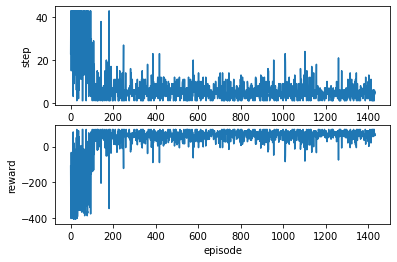

CPU times: user 3min 7s, sys: 12.8 s, total: 3min 19s
Wall time: 3min 53s


In [9]:
%%time
width = 64
height = 48
GL = 18
GH = 36
middle=GH-GL
ENV_NAME = 'VizdoomBasic-v0'

from keras.layers import Dropout

from vizdoomgym.envs.vizdoom_env_definitions import VizdoomBasic
class MyBasic(VizdoomBasic):
    def step(self, action):
        act = np.zeros(self.action_space.n)
        act[action] = 1
        act = np.uint8(act)
        act = act.tolist()
        reward = self.game.make_action(act)
        self.state = self.game.get_state()
        done = self.game.is_episode_finished()
        info = {"dummy": 0.0}
        return self.collect_observations(), reward, done, info
    def reset(self):
        self.game.new_episode()
        self.state = self.game.get_state()
        return self.collect_observations()
    def collect_observations(self):
        if self.state is not None:
            obs = np.transpose(self.state.screen_buffer, (1, 2, 0))
        else:
            obs = np.zeros(self.observation_space.shape, dtype=np.uint8)
        obs = cv2.resize(obs,(width,height))[GL:GH,:]
        # obs = cv2.cvtColor(obs,cv2.COLOR_RGB2GRAY)
        observation = np.reshape(obs,(middle,width,3))/255
        return observation

# env = gym.make(ENV_NAME, depth=False,bels=False, position=False, health=False)
env = MyBasic(depth=False,bels=False, position=False, health=False)
input_shape = env.observation_space.shape
nb_actions = env.action_space.n
# DQN
model = Sequential()
model.add(Reshape((middle,width,3),input_shape=(1,middle,width,3)))
model.add(Conv2D(24, (5, 5), activation='relu',strides=(4,4),padding="same"))
model.add(Conv2D(24, (5, 5), activation='relu',padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(24, activation='relu'))
model.add(Dense(nb_actions, activation='linear'))
#model.add(Dense(nb_actions, activation='softmax'))
print(model.summary())

memory = SequentialMemory(limit=10000, window_length=1)
policy = EpsGreedyQPolicy(eps=0.3)
#env = gym.make('VizdoomBasic-v0', depth=False, labels=False, position=False, health=False)
dqn = DQNAgent(model=model, nb_actions=nb_actions,policy=policy,gamma=0.99, memory=memory, enable_double_dqn=True,
                target_model_update=0.05,dueling_type='avg',nb_steps_warmup=1000)
dqn.compile(Adam(lr=0.006), metrics=['mae'])
history = dqn.fit(env, nb_steps=10000, action_repetition=7,visualize=False, verbose=1)
dqn.save_weights('/content/drive/My Drive/tmp/vizdoomgym/dqn1_{}_params.h5f'.format(ENV_NAME), overwrite=True)
# 結果を表示

plt.subplot(2,1,1)
plt.plot(history.history["nb_episode_steps"])
plt.ylabel("step")
plt.subplot(2,1,2)
plt.plot(history.history["episode_reward"])
plt.xlabel("episode")
plt.ylabel("reward")
plt.show() 

# dqn.test(env, nb_episodes=5, visualize=True)